# <center> Train TrOCR on Deseret Dataset </center>

## Preprocessing

### Load the model

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

checkpoint = "microsoft/trocr-base-printed"
processor = TrOCRProcessor.from_pretrained(checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

### Load the data

In [2]:
from datasets import load_dataset

deseret_data = load_dataset("cayjobla/iam-deseret", split="train")

In [3]:
# Split the dataset
deseret_data = deseret_data.train_test_split(test_size=0.2)
deseret_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'english', 'deseret'],
        num_rows: 9075
    })
    test: Dataset({
        features: ['image', 'label', 'english', 'deseret'],
        num_rows: 2269
    })
})

at a piece called " piccadilly " ( polydor ) . i find it cute .
𐐲𐐻 𐐩 𐐹𐐨𐑅 𐐿𐐫𐑊𐐼 " 𐐹𐐮𐐿𐐲𐐼𐐮𐑊𐐨 " ( polydor ) . 𐐴 𐑁𐐴𐑌𐐼 𐐮𐐻 𐐿𐐷𐐭𐐻 .


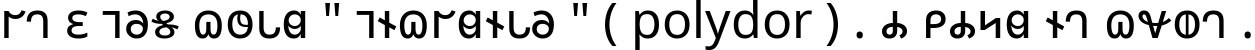

In [4]:
# Look at an example from the dataset
index = 128
print(deseret_data["train"][index]["english"])
print(deseret_data["train"][index]["deseret"])
display(deseret_data["train"][index]["image"])

### Create a custom dataset for preprocessing

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class DeseretIAMDataset(Dataset):
    def __init__(self, data, processor, max_target_length=128):
        self._data = data
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        image = self._data[idx]["image"]
        text = self._data[idx]["english"]
        
        # Preprocessing
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(
            text, 
            padding="max_length",
            max_length=self.max_target_length,
            return_tensors="pt"
        ).input_ids

        # Ignore the padding tokens
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {"pixel_values": pixel_values.squeeze(), "labels": labels.squeeze()}

In [6]:
train_dataset = DeseretIAMDataset(deseret_data["train"], processor)
test_dataset = DeseretIAMDataset(deseret_data["test"], processor)

at a piece called " piccadilly " ( polydor ) . i find it cute .


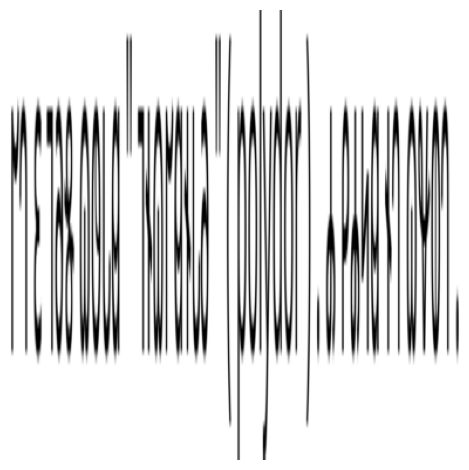

In [7]:
import torchshow

example = train_dataset[index]
pixel_values, labels = example["pixel_values"], example["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id   # Allow to decode
print(processor.decode(labels, skip_special_tokens=True))
torchshow.show(pixel_values)

## Prep for training

In [8]:
# Set special tokens
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [9]:
# NOTE: This is to downsample the data for testing
train_dataset = DeseretIAMDataset(
    deseret_data["train"].train_test_split(test_size=1000)["train"], 
    processor
)
test_dataset = DeseretIAMDataset(
    deseret_data["test"].train_test_split(test_size=100)["train"], 
    processor
)

In [10]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=1,
    save_steps=500,
    eval_steps=500,
)

/home/cayjobla/OCRTranslator/.venv/lib64/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
import evaluate

cer_metric = evaluate.load("cer")

In [12]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator
)

/home/cayjobla/OCRTranslator/.venv/lib64/python3.11/site-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipykernel_1538436/1909754273.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


TypeError: Seq2SeqTrainer.__init__() got an unexpected keyword argument 'device'

## Train

In [ ]:
trainer.train()